# A방송사 댓글 감성 분류
+ 이번 시간에는 A방송사 댓글 데이터를 이용해서 감성분류해 보도록 하겠습니다.
+ A방송사 댓글 데이터를 전처리하고, keras 토큰나이져를 활용하여 토큰화하고 일정 크기의 문장으로 맞추기 위해 패딩합니다.
+ 또한, embedding 레이어를 이용해서 단어를 n차원 밀집벡터를 만들고 train시에 학습되도록 합니다.
+ LSTM 언어 모델과 DNN 합쳐서 감성분류를 수행합니다.

## 자연어 처리 순서
> 토큰나이져(단어를 숫자매핑, 단어사전 만들기) > 문장을 숫자 나열(texts_to_sequences) > 문장 길이 맞게 Padding > Embedding(단어를 의미있는 밀집 Vector 표현) > 모델링

### 실습 처리 순서 

1. 라이브러리 임포트
2. 파일 읽어오기
3. 특수문자 제거 : 한글, 특수문제 제거
4. 전처리 : Null, 중복 제거
5. Label 분포 확인
6. label 숫자로 인코딩
7. X, Y 분리
8. train set와 test set 분리
9. 전체 문장에 대해 Tokenizing
10. texts_to_sequences : 문장을 숫자로 나열
11. Padding Sequence
12. Modeling : Embedding, LSTM

## 1. 라이브러리 임포트

In [1]:
# pandas read_excel 함수에서 엑셀을 읽기 위한 패키지 설치
!pip install openpyxl

import numpy as np
import pandas as pd

## 2. 파일 읽어오기

In [2]:
# 데이터 읽어오기 
final_data = pd.read_excel('https://github.com/gzone2000/TEMP_TEST/raw/master/A_comment_train.xlsx', engine='openpyxl')

In [3]:
final_data.head()

,Unnamed: 0,data,label
0,0,재미는 있는데 시간이 짧은게 아쉽네요~,긍정
1,1,"OO 관련 내용은 우리 직원과는 거리가 멀었음, 특히, 사내에 홍보할 내용은 아니라고 봄",부정
2,2,스토리가 너무 딱딱해서 별로였음,부정
3,3,프로그램A 화이팅하세요!!,긍정
4,4,높은 곳에 올라가는 모습이 너무 위험해 보여요.,부정


In [4]:
# 총 251건
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  251 non-null    int64 
 1   data        251 non-null    object
 2   label       251 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.0+ KB


## 3. 특수문자 제거

In [5]:
# data 컬럼의 내용중에 영문, 특수문자 있는지 확인 : 영문과 특수문자 존재 확인
final_data[final_data['data'].str.contains('[^가-힣 ]')].values[:10]

array([[0, '재미는 있는데 시간이 짧은게 아쉽네요~', '긍정'],
       [1, 'OO 관련 내용은 우리 직원과는 거리가 멀었음, 특히, 사내에 홍보할 내용은 아니라고 봄', '부정'],
       [3, '프로그램A 화이팅하세요!!', '긍정'],
       [4, '높은 곳에 올라가는 모습이 너무 위험해 보여요.', '부정'],
       [5,
        '너무 재밌게 잘봤습니다~! ㅋㅋ\n송OO씨가 출근하자마자 안마의자 앉아서 쉬는게 부럽기도(?) 했네요\n쇼호스트분들의 진행솜씨또한 감탄하고 갑니다. 다음은 어디 외부 탐방 예정인가요?!',
        '긍정'],
       [6, '비유가 너무 찰떡이에요! ', '긍정'],
       [7, '광고가 섭외된 모델이랑 너무 찰떡이네요. 목소리가 너무 잘 어울려요. ', '긍정'],
       [8,
        '이달의 픽은 재미 싹쓰리입니다. 요즘 온라인에 재밌는 영상과 사진이 너무 많아서 읽다보면 시간 가는 줄 모릅니다.',
        '긍정'],
       [11, '내용이 와닿지 않아요. 좀 더 실제와 같았으면 하네요..', '부정'],
       [12, '미숙한 진행으로 전체적으로 지루함을 느꼈어요.', '부정']], dtype=object)

In [6]:
# data 컬럼의 내용에서 숫자, 영문자, 공백등의 글자는 삭제처리
final_data['data'] = final_data['data'].str.replace('[^가-힣 ]','')

In [7]:
# data 컬럼의 내용에서 영문, 특수문자 없음 확인
final_data['data'][final_data['data'].str.contains('[^가-힣 ]')].sum()

0

## 4. 전처리

In [8]:
# final_data 어떤 컬럼과 내용으로 되어 있는지 파악
final_data.tail()

,Unnamed: 0,data,label
246,246,영상서비스로 간편하게 설치좋아요우리 회사화이팅,긍정
247,247,모든 업무에서 맡은바 업무에 서 최선을 다하는 모습이 좋습니다 화이팅 입니다,긍정
248,248,사내방송 특성상 최근 이슈화 되거나 언급이 자주되는 키워드를 중심으로 뉴스를 구성하...,부정
249,249,방송 시간이 너무 길어요,부정
250,250,처음 들어보는 말들이 많은데 설명이 없어서 힘드네요,부정


In [9]:
# data 컬럼의 내용을 양끝의 빈공간 삭제
final_data['data'] = final_data['data'].str.strip()

In [10]:
final_data.tail()

,Unnamed: 0,data,label
246,246,영상서비스로 간편하게 설치좋아요우리 회사화이팅,긍정
247,247,모든 업무에서 맡은바 업무에 서 최선을 다하는 모습이 좋습니다 화이팅 입니다,긍정
248,248,사내방송 특성상 최근 이슈화 되거나 언급이 자주되는 키워드를 중심으로 뉴스를 구성하...,부정
249,249,방송 시간이 너무 길어요,부정
250,250,처음 들어보는 말들이 많은데 설명이 없어서 힘드네요,부정


In [11]:
# 필요없는 'Unnamed: 0' 컬럼 삭제
final_data = final_data.drop(['Unnamed: 0'], axis=1)

In [12]:
final_data.tail()

,data,label
246,영상서비스로 간편하게 설치좋아요우리 회사화이팅,긍정
247,모든 업무에서 맡은바 업무에 서 최선을 다하는 모습이 좋습니다 화이팅 입니다,긍정
248,사내방송 특성상 최근 이슈화 되거나 언급이 자주되는 키워드를 중심으로 뉴스를 구성하...,부정
249,방송 시간이 너무 길어요,부정
250,처음 들어보는 말들이 많은데 설명이 없어서 힘드네요,부정


In [13]:
# Null 있는지 확인
final_data.isnull().sum()

data     0
label    0
dtype: int64

In [14]:
# 중복 데이터 있는지 확인 : 2건 중복 존재 확인
final_data['data'].duplicated().sum()

2

In [15]:
# 중복 데이터 제거
final_data.drop_duplicates(subset=['data'], inplace=True)

In [16]:
# 기존 251 --> 이후 249 : 2건 중복 삭제 확인
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 0 to 250
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    249 non-null    object
 1   label   249 non-null    object
dtypes: object(2)
memory usage: 5.8+ KB


## 5. Label 분포 확인

In [17]:
# 한글 그래프 그리기
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# fm.get_fontconfig_fonts()
plt.rc('font', family='NanumGothicCoding')

<AxesSubplot:>

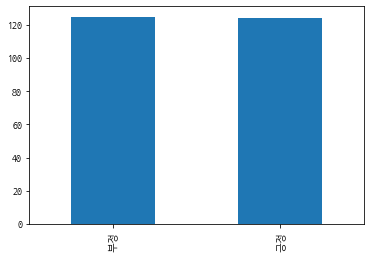

In [18]:
# plot Bar차트 그리기
final_data['label'].value_counts().plot(kind='bar')

## 6. label 숫자로 인코딩

In [19]:
label2class = {'긍정':0, '부정':1}
class2label = {0:'긍정', 1:'부정'}
final_data['label'] = final_data['label'].map(label2class)

In [20]:
final_data.head()

,data,label
0,재미는 있는데 시간이 짧은게 아쉽네요,0
1,관련 내용은 우리 직원과는 거리가 멀었음 특히 사내에 홍보할 내용은 아니라고 봄,1
2,스토리가 너무 딱딱해서 별로였음,1
3,프로그램 화이팅하세요,0
4,높은 곳에 올라가는 모습이 너무 위험해 보여요,1


In [21]:
# DataFrame 저장
final_data.to_csv('A_comment.csv',index=False)

## 7. X, Y 분리

In [22]:
# X, Y 분리 
features = final_data['data'].values
labels = final_data['label'].values

In [23]:
features.shape, labels.shape

((249,), (249,))

In [24]:
# features 내용 3개 출력
features[:3]

array(['재미는 있는데 시간이 짧은게 아쉽네요',
       '관련 내용은 우리 직원과는 거리가 멀었음 특히 사내에 홍보할 내용은 아니라고 봄',
       '스토리가 너무 딱딱해서 별로였음'], dtype=object)

In [25]:
print('이벤트 문자열 최대 길이 :{}'.format(max(len(l) for l in features)))
print('이벤트 문자열 평균 길이 :{}'.format(sum(map(len, features))/len(features)))

이벤트 문자열 최대 길이 :160
이벤트 문자열 평균 길이 :43.91967871485944


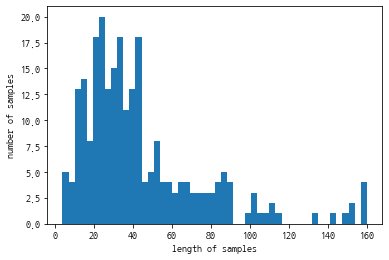

In [26]:
plt.hist([len(s) for s in features], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 8. train set와 test set 분리

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, labels , test_size=0.2, stratify=labels, random_state=41)
x_train.shape, x_test.shape

((199,), (50,))

In [28]:
# 샘플확인 , 0:긍정, 1:부정
x_train[:2], y_train[:2]

(array(['저도 입사 개월 갓 지난 신입사원으로써 많이 공감되는 부분이 있고 완전 판매를 위해서 꼼꼼히 케어하여 업무처리해야겠다고 생각되었습니다 매장에서 적용할 부분들에 대해서도 도움이 되고 유쾌하게 풀어내어 이래저래 꾸준히 챙겨보고 있습니다 감사합니다',
        '매 방송마다 신선한 아이디어가 많이 도출되는 것 같아요'], dtype=object),
 array([0, 0]))

## 9. 전체 문장에 대해 Tokenizing
+ 컴퓨터가 이해하기 위해 모든 단어를 숫자로 변환해야 함.
+ 단어 빈도수 따지지 않고 무조건 모든 단어 수용해서 진행

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
# Tokenizer 구현 : 단어 사전 만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [31]:
# 단어에 대한 숫자 매핑
print(tokenizer.word_index)

{'우리': 1, '너무': 2, '것': 3, '잘': 4, '더': 5, '같습니다': 6, '같아요': 7, '좋은': 8, '대한': 9, '수': 10, '좀': 11, '감사합니다': 12, '어떤': 13, '조금': 14, '회사의': 15, '있는': 16, '많이': 17, '회사': 18, '항상': 19, '부분이': 20, '재밌게': 21, '재미있게': 22, '방송': 23, '하는': 24, '프로그램': 25, '정말': 26, '도움이': 27, '고객의': 28, '새로운': 29, '좋겠습니다': 30, '사내': 31, '있었습니다': 32, '방송은': 33, '보고': 34, '응원합니다': 35, '통해': 36, '가장': 37, '쇼핑': 38, '앞으로도': 39, '있습니다': 40, '보는': 41, '어떻게': 42, '보았습니다': 43, '기대됩니다': 44, '차별화된': 45, '다소': 46, '금일': 47, '회사가': 48, '기업이미지': 49, '시간': 50, '아쉬웠습니다': 51, '화이팅': 52, '다양한': 53, '좋을': 54, '합니다': 55, '유익한': 56, '없는': 57, '기획': 58, '많은': 59, '한': 60, '방송이': 61, '서비스': 62, '됩니다': 63, '저도': 64, '케어하여': 65, '되고': 66, '신선한': 67, '전혀': 68, '있어': 69, '잘봤습니다': 70, '최근': 71, '계속': 72, '있었으면': 73, '이미지': 74, '기업의': 75, '참': 76, '있네요': 77, '봤습니다': 78, '아쉽습니다': 79, '있을': 80, '하고': 81, '있는지': 82, '같네요': 83, '함께': 84, '재미있고': 85, '제': 86, '픽은': 87, '마음을': 88, '서비스에': 89, '내용이': 90, '이번': 91, '입니다': 92, '업무를': 93, '모습을':

In [32]:
# 반대로 숫자로 단어 매핑
print(tokenizer.index_word)

{1: '우리', 2: '너무', 3: '것', 4: '잘', 5: '더', 6: '같습니다', 7: '같아요', 8: '좋은', 9: '대한', 10: '수', 11: '좀', 12: '감사합니다', 13: '어떤', 14: '조금', 15: '회사의', 16: '있는', 17: '많이', 18: '회사', 19: '항상', 20: '부분이', 21: '재밌게', 22: '재미있게', 23: '방송', 24: '하는', 25: '프로그램', 26: '정말', 27: '도움이', 28: '고객의', 29: '새로운', 30: '좋겠습니다', 31: '사내', 32: '있었습니다', 33: '방송은', 34: '보고', 35: '응원합니다', 36: '통해', 37: '가장', 38: '쇼핑', 39: '앞으로도', 40: '있습니다', 41: '보는', 42: '어떻게', 43: '보았습니다', 44: '기대됩니다', 45: '차별화된', 46: '다소', 47: '금일', 48: '회사가', 49: '기업이미지', 50: '시간', 51: '아쉬웠습니다', 52: '화이팅', 53: '다양한', 54: '좋을', 55: '합니다', 56: '유익한', 57: '없는', 58: '기획', 59: '많은', 60: '한', 61: '방송이', 62: '서비스', 63: '됩니다', 64: '저도', 65: '케어하여', 66: '되고', 67: '신선한', 68: '전혀', 69: '있어', 70: '잘봤습니다', 71: '최근', 72: '계속', 73: '있었으면', 74: '이미지', 75: '기업의', 76: '참', 77: '있네요', 78: '봤습니다', 79: '아쉽습니다', 80: '있을', 81: '하고', 82: '있는지', 83: '같네요', 84: '함께', 85: '재미있고', 86: '제', 87: '픽은', 88: '마음을', 89: '서비스에', 90: '내용이', 91: '이번', 92: '입니다', 93: '업무를', 94: '모

In [33]:
# 단어별 빈도수 확인
print(tokenizer.word_counts)

OrderedDict([('저도', 3), ('입사', 1), ('개월', 1), ('갓', 1), ('지난', 1), ('신입사원으로써', 1), ('많이', 8), ('공감되는', 1), ('부분이', 7), ('있고', 1), ('완전', 1), ('판매를', 1), ('위해서', 1), ('꼼꼼히', 2), ('케어하여', 3), ('업무처리해야겠다고', 2), ('생각되었습니다', 2), ('매장에서', 2), ('적용할', 2), ('부분들에', 2), ('대해서도', 2), ('도움이', 6), ('되고', 3), ('유쾌하게', 2), ('풀어내어', 2), ('이래저래', 2), ('꾸준히', 1), ('챙겨보고', 1), ('있습니다', 4), ('감사합니다', 10), ('매', 1), ('방송마다', 1), ('신선한', 3), ('아이디어가', 1), ('도출되는', 1), ('것', 33), ('같아요', 14), ('아직은', 1), ('들이', 2), ('미숙해보이네요', 1), ('어색한', 1), ('말이', 2), ('들려요', 1), ('저희', 2), ('우리', 35), ('회사직원분들과', 1), ('호흡도', 1), ('좋았고', 1), ('진행이', 2), ('상당히', 1), ('매끄로워', 1), ('보는', 4), ('내내', 1), ('즐거웠습니다', 1), ('직원분들도', 1), ('전혀', 3), ('꿀리는거', 1), ('없이', 1), ('너무', 35), ('능숙해', 1), ('지셨네요', 1), ('분량이', 1), ('치우쳐', 1), ('있어', 3), ('앞부분의', 1), ('내용은', 2), ('기억에', 2), ('잘', 28), ('안남는', 1), ('같습니다', 18), ('고객의', 6), ('입장에서', 1), ('생각하면', 1), ('새로운', 6), ('트렌드가', 1), ('보이는', 2), ('재밌게', 7), ('잘봤습니다', 3), ('송씨가', 1), ('출근하

In [34]:
# 총 단어 갯수 : 1418
max_words = len(tokenizer.index_word)
print(max_words)

1418


## 10. texts_to_sequences : 문장을 숫자로 나열
- 빈도수 적은 단어 제외하는것 없이 모든 단어 포함해서 진행

In [35]:
# 문장을 숫자로 나열 
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [36]:
print(len(x_train_seq), len(x_test_seq))

199 50


In [37]:
print(x_train[1:3])
print(x_train_seq[1:3])

['매 방송마다 신선한 아이디어가 많이 도출되는 것 같아요' '아직은 들이 미숙해보이네요 어색한 말이 많이 들려요']
[[311, 312, 67, 313, 17, 314, 3, 7], [315, 133, 316, 317, 134, 17, 318]]


## 11. Padding Sequence

In [38]:
# 문장의 최대 길이 파악
max(len(line) for line in x_train_seq)

36

In [39]:
# 모든 문장을 최대 문장 길이 36에 맞춘다.
x_train_pad = pad_sequences(x_train_seq, maxlen=36)
x_test_pad = pad_sequences(x_test_seq, maxlen=36)

In [40]:
x_train_pad[:1]

array([[  0,   0,   0,   0,   0,   0,  64, 299, 300, 301, 302, 303,  17,
        304,  20, 305, 306, 307, 308, 123,  65, 124, 125, 126, 127, 128,
        129,  27,  66, 130, 131, 132, 309, 310,  40,  12]], dtype=int32)

In [41]:
x_train_pad.shape, x_test_pad.shape

((199, 36), (50, 36))

## 12. 모델링

In [42]:
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPool2D
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, SimpleRNN, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [43]:
# 하이퍼 파라미터 

max_words = 1418 + 1    # 총 단어 갯수 + padding 0 번호
max_len = 36             # 최대 문장 길이
embedding_dim = 32      # embedding 차원

In [44]:
# 모델 선언
model = Sequential()

In [45]:
# 단어를 의미있는 32 차원으로 Vector 변경
model.add(Embedding(max_words, embedding_dim, input_length=max_len))

In [46]:
model.add(LSTM(16, return_sequences=True))
model.add(Flatten())
model.add(Dense(128, activation='swish'))
model.add(Dense(32, activation='swish'))
model.add(Dense(2, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = 'accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 32)            45408     
_________________________________________________________________
lstm (LSTM)                  (None, 36, 16)            3136      
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               73856     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 126,594
Trainable params: 126,594
Non-trainable params: 0
__________________________________________________

In [47]:
# 조기종료 콜백함수 정의
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# 체크포인트 저장
checkpoint_path = 'tmp_checkpoint.ckpt'
cp = ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor='val_loss',
                               verbose=1, save_best_only=True) 

In [48]:
%%time
history = model.fit(x_train_pad, y_train, epochs=50, batch_size=512, 
                      validation_split=0.2, verbose =1, callbacks=[es, cp])

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.6931 - accuracy: 0.4591 - val_loss: 0.6939 - val_accuracy: 0.4500

Epoch 00001: val_loss improved from inf to 0.69390, saving model to tmp_checkpoint.ckpt
Epoch 2/50
1/1 [==============================] - 0s 56ms/step - loss: 0.6914 - accuracy: 0.5849 - val_loss: 0.6940 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 0.69390
Epoch 3/50
1/1 [==============================] - 0s 50ms/step - loss: 0.6892 - accuracy: 0.5849 - val_loss: 0.6943 - val_accuracy: 0.5250

Epoch 00003: val_loss did not improve from 0.69390
Epoch 4/50
1/1 [==============================] - 0s 64ms/step - loss: 0.6865 - accuracy: 0.5849 - val_loss: 0.6947 - val_accuracy: 0.5250

Epoch 00004: val_loss did not improve from 0.69390
Epoch 5/50
1/1 [==============================] - 0s 171ms/step - loss: 0.6829 - accuracy: 0.5849 - val_loss: 0.6953 - val_accuracy: 0.5250

Epoch 00005: val_loss did not improve from 0.69390
Epoch 6/5

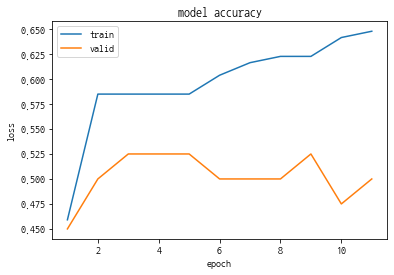

In [49]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], )
plt.show()

In [50]:
model.evaluate(x_test_pad, y_test)

2/2 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.5200


[0.7007135152816772, 0.5199999809265137]

### 예측해 보기

In [51]:
print(f'문자열 : {x_test[0]}')
print(f'Sequence : {x_test_pad[0]}')

문자열 : 관련 내용은 우리 직원과는 거리가 멀었음 특히 사내에 홍보할 내용은 아니라고 봄
Sequence : [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 481 137   1 137]


In [52]:
predict = model.predict(x_test_pad[:1])

In [53]:
print(f'True : {class2label[y_test[0]]}')
print(f'Predict : {class2label[np.argmax(predict)]}')

True : 부정
Predict : 부정
